# Linear regression analysis

## Roadmap of this notebook: 
- Merge in, do some last-minute cleaning of data
  - Quick-maths bar graph
  - IMDB, Metacritic, RottenTomatoes, discussion on imputing mean for N/As, and why we will not use RottenTomaotes data moving forward, and only go with IMDb
  - Result: 2,601 rows
- Analyze
  - Train/val/holdout split
  - One-hot-encoding of genre
  - Target variable as IMDb
  - Baseline linear regression (R^2 = ?)
  - **** FEATURE ENGINEERING *****
  - Add interaction terms between genres (Horror Thriller for instance)
  - R^2 = ?
  - Add polynomial interaction term between domestic/international and genre
  - R^2 = ?
  - 
  

In [1]:
import pandas as pd
import glob
from functools import reduce
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
mojo = pd.read_csv('data/mojo_revised.csv')
imdb = pd.read_csv('data/imdb.csv')
metacritic = pd.read_csv('data/metacritic.csv')
tomato = pd.read_csv('data/rotten_tomatoes.csv')
heirloom = pd.read_csv('data/heirloom.csv')
mojo.rename(columns={"title": "mojo_title"}, inplace=True)
heirloom.set_index(['mojo_title'])
mojo.set_index(['mojo_title'])
imdb.set_index(['mojo_title'])
metacritic.set_index(['mojo_title'])
tomato.set_index(['mojo_title'])

mojo['mojo_title'].count

<bound method Series.count of 0                                          Made in France
1                                                  Realms
2                                   Postcards from London
3                                          Over the Limit
4       Tall Tales from the Magical Garden of Antoon K...
                              ...                        
3102        Star Wars: Episode IX - The Rise of Skywalker
3103                              Jumanji: The Next Level
3104                                   Sonic the Hedgehog
3105                                                 1917
3106                                    Bad Boys for Life
Name: mojo_title, Length: 3107, dtype: object>

In [3]:
#Our webscraping resulted in some unwanted duplicates (it can be due to a variety of reasons)
#As a result, after verifying they contain the same information, I will remove them
mojo[mojo.duplicated(subset=['mojo_title'])].sort_values(by='mojo_title').head(10)
mojo = mojo.drop_duplicates(subset=['mojo_title'])

# House-cleaning: have to merge heirloom into tomato

In [4]:
tomato.shape

(2771, 6)

In [5]:
heirloom.shape

(2685, 5)

In [6]:
tomato_final = tomato.merge(heirloom, on='mojo_title', how='left')

In [7]:
tomato_final.shape

(2771, 10)

In [8]:
tomato_final = tomato_final.drop(['url_y', 'tomato_criticcount_x'], axis=1)

In [9]:
tomato_final = tomato_final.rename(columns={"tomato_criticcount_y":"tomato_criticcount", "url_x":"url"})


In [10]:
tomato_final = tomato_final.dropna(subset=['tomato_image'])

In [11]:
def get_img_url(df):  
    return re.findall('(?<=data-src).*$', df)[0][2:-2]
tomato_final['tomato_image'] = tomato_final['tomato_image'].apply(get_img_url)

In [12]:
tomato_final.shape

(2658, 8)

## Mojo is our primary dataset. Let's see if we have an even amount across the years.

In [13]:
mojo['release_year'] = [x.strip()[-4:] for x in mojo['release_days'].astype(str)]


In [14]:
movies_in_year = [pd.to_numeric(mojo['mojo_title'][mojo['release_year'] == '2016'].shape)[0], 
                  pd.to_numeric(mojo['mojo_title'][mojo['release_year'] == '2017'].shape)[0], 
                  pd.to_numeric(mojo['mojo_title'][mojo['release_year'] == '2018'].shape)[0], 
                  pd.to_numeric(mojo['mojo_title'][mojo['release_year'] == '2019'].shape)[0], 
                  pd.to_numeric(mojo['mojo_title'][mojo['release_year'] == '2020'].shape)[0]]

In [15]:
movies_in_year

[98, 682, 825, 760, 298]

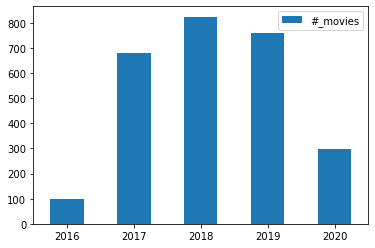

In [16]:
index = ['2016', '2017', '2018',
         '2019', '2020']
df_plot = pd.DataFrame({'#_movies': movies_in_year}, index=index)
ax = df_plot.plot.bar(rot=0)

## Merge in IMDB

In [17]:
# mojo.drop_duplicates(subset='mojo_title', inplace=True)
imdb.drop_duplicates(subset='mojo_title', inplace=True)

mojo['mojo_title'] = mojo['mojo_title'].str.strip()
imdb['mojo_title'] = imdb['mojo_title'].str.strip()

In [18]:
mojo['mojo_title'].count

<bound method Series.count of 0                                          Made in France
1                                                  Realms
2                                   Postcards from London
3                                          Over the Limit
4       Tall Tales from the Magical Garden of Antoon K...
                              ...                        
3098                                    The Invisible Man
3100                                             Dolittle
3101                                        Birds of Prey
3104                                   Sonic the Hedgehog
3106                                    Bad Boys for Life
Name: mojo_title, Length: 2777, dtype: object>

In [19]:
df1 = mojo.merge(imdb, on='mojo_title', how='left')

#This does not return 3107 rows, it returns 3369. I checked below that these duplicates are in fact the exact same
#across columns and that no information loss occurs.
#
#As a result, it is OK by me to just drop these duplicates.


In [20]:
df1['mojo_title'].count

<bound method Series.count of 0                                          Made in France
1                                                  Realms
2                                   Postcards from London
3                                          Over the Limit
4       Tall Tales from the Magical Garden of Antoon K...
                              ...                        
2772                                    The Invisible Man
2773                                             Dolittle
2774                                        Birds of Prey
2775                                   Sonic the Hedgehog
2776                                    Bad Boys for Life
Name: mojo_title, Length: 2777, dtype: object>

Row count still == 2777. Merge worked.

## Merge in metacritic
1) Drop duplicates

In [21]:
metacritic['mojo_title'].count

<bound method Series.count of 0       Star Wars: Episode VIII - The Last Jedi
1                           Annabelle: Creation
2                  Murder on the Orient Express
3                                Daddy's Home 2
4                           Fifty Shades Darker
                         ...                   
1966                                      Logan
1967                            Despicable Me 3
1968                             Thor: Ragnarok
1969                     Spider-Man: Homecoming
1970             Guardians of the Galaxy Vol. 2
Name: mojo_title, Length: 1971, dtype: object>

In [22]:
metacritic.drop_duplicates(subset='mojo_title', inplace=True)

In [23]:
metacritic['mojo_title'].count

<bound method Series.count of 0       Star Wars: Episode VIII - The Last Jedi
1                           Annabelle: Creation
2                  Murder on the Orient Express
3                                Daddy's Home 2
4                           Fifty Shades Darker
                         ...                   
1966                                      Logan
1967                            Despicable Me 3
1968                             Thor: Ragnarok
1969                     Spider-Man: Homecoming
1970             Guardians of the Galaxy Vol. 2
Name: mojo_title, Length: 1822, dtype: object>

In [24]:
df2 = df1.merge(metacritic, on='mojo_title', how='left')

In [25]:
df2['mojo_title'].count

<bound method Series.count of 0                                          Made in France
1                                                  Realms
2                                   Postcards from London
3                                          Over the Limit
4       Tall Tales from the Magical Garden of Antoon K...
                              ...                        
2772                                    The Invisible Man
2773                                             Dolittle
2774                                        Birds of Prey
2775                                   Sonic the Hedgehog
2776                                    Bad Boys for Life
Name: mojo_title, Length: 2777, dtype: object>

Row count still == 2,777. Merge worked.

## Merge in RottenTomatoes

1) Drop duplicates

In [26]:
tomato_final['mojo_title'].count

<bound method Series.count of 1                Annabelle: Creation
2       Murder on the Orient Express
3                     Daddy's Home 2
4                        Baby Driver
5                Fifty Shades Darker
                    ...             
2765         The Fate of the Furious
2766                           Logan
2767                 Despicable Me 3
2768                              It
2769          Spider-Man: Homecoming
Name: mojo_title, Length: 2658, dtype: object>

In [27]:
tomato_final.drop_duplicates(subset='mojo_title', inplace=True)

In [28]:
tomato_final['mojo_title'].count

<bound method Series.count of 1                Annabelle: Creation
2       Murder on the Orient Express
3                     Daddy's Home 2
4                        Baby Driver
5                Fifty Shades Darker
                    ...             
2765         The Fate of the Furious
2766                           Logan
2767                 Despicable Me 3
2768                              It
2769          Spider-Man: Homecoming
Name: mojo_title, Length: 2658, dtype: object>

In [29]:
df = df2.merge(tomato_final, on='mojo_title', how='left')

In [30]:
df['mojo_title'].count

<bound method Series.count of 0                                          Made in France
1                                                  Realms
2                                   Postcards from London
3                                          Over the Limit
4       Tall Tales from the Magical Garden of Antoon K...
                              ...                        
2772                                    The Invisible Man
2773                                             Dolittle
2774                                        Birds of Prey
2775                                   Sonic the Hedgehog
2776                                    Bad Boys for Life
Name: mojo_title, Length: 2777, dtype: object>

Row count still == 2,777. Merge worked.

Sanity check: do we have any duplicates. Notice that now I am looking at **tomato_title** from RottenTomatoes. This'll tell us if BoxOfficeMojo thinks a movie's unique, but RottenTomatoes thinks the two are identical.

In [31]:
boolean = not df["tomato_title"].is_unique      
boolean = df['tomato_title'].duplicated().any() 
boolean

True

Answer: yes! Duplicates == "N/A" from Rotten Tomatoes. This can be proved by firstly finding that there are 120 
duplicated rows.

In [32]:
len(df[df.duplicated(subset=['tomato_title'])].sort_values(by='mojo_title'))

120

In [33]:
df[df.duplicated(subset=['tomato_title'])].sort_values(by='mojo_title').head()

,mojo_title,domestic_revenue,international_reveneue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,...,mc_criticcount,mc_audiencescore,mc_audiencecount,url,tomato_title,tomato_criticscore,tomato_audiencescore,tomato_criticcount,tomato_audiencecount,tomato_image
2684,100% Wolf,"$512,805","$4,101,865","$4,614,670",Viva Pictures,NaN,124 theaters,NaN,PG,"Adventure, Animation, Comedy, Family, Fantasy",...,15,No score yet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
677,1917,"$159,227,644","$225,679,098","$384,906,742",Universal Pictures,"$576,216","3,987 theaters","$95,000,000",R,"Drama, Thriller, War",...,57,8.4,812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2734,2020 Oscar Nominated Short Films,"$3,306,611",NaN,"$3,306,611",Magnolia Pictures,"$1,155,505",536 theaters,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1767,2:22,$422,"$3,945,307","$3,945,729",Magnolia Pictures,$294,3 theaters,NaN,PG-13,"Drama, Mystery, Sci-Fi, Thriller",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,42nd Street: The Musical,"$187,440","$1,834,653","$2,022,093",Fathom Events,NaN,515 theaters,NaN,Not Rated,Musical,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df['tomato_title'].isnull().sum(axis = 0)

121

*Note*: numbers differ by 1 due to len starting at 0, sum does not.

## How to handle null review values?

This will become a topic of discussion that is at the heart of *all* our wonder,
how to count when our values stray from read-able? 

What is a "NaN" review? Why are the values "N/A"?

The answer comes from our webscraper code. "N/A" happens when the site could not be found; this is just part of what
we accept when the code relies on a search algorithm to hopefully find us a movie link from a movie name. 

It's possible RottenTomatoes does not score international movies, for instance, so they lack critical pieces
of our population - these N/A are non-random, we can't ignore.

**What now?**

We cannot disregard these movies -- they are important pieces of data.

As it will turn out later in our review, **rotten tomatoes scores are highly non-normal** so they are seemingly
untrustworthy anyway. Using this information, we will set them to the average of the RottenTomatoes distribution
(the mean), which we find below.

In [35]:
tomato_scores = df
tomato_scores.dropna(subset=['tomato_title'], inplace=True)
tomato_scores['tomato_title'].isnull().sum(axis=0)

0

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


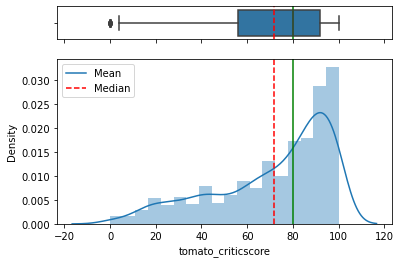

In [36]:
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['tomato_criticscore'].mean()
median=df['tomato_criticscore'].median()

sns.boxplot(df["tomato_criticscore"], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.distplot(df["tomato_criticscore"], ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})

ax_box.set(xlabel='')
plt.show()

*Take-away*: RottenTomatoes critic scores are heavily skewed left, the mean is to the right of the peak (=71.52). 
This indicates "review inflation", where more reviews tend to be positive, even in the 90-100 range.

### Just for fun, we can also do this for audience scores on Rotten Tomatoes

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


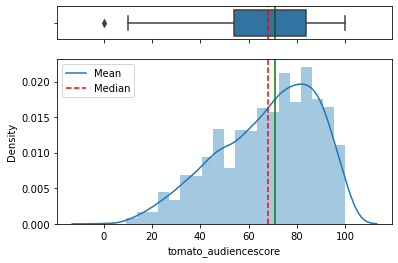

In [37]:
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['tomato_audiencescore'].mean()
median=df['tomato_audiencescore'].median()

sns.boxplot(df["tomato_audiencescore"], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.distplot(df["tomato_audiencescore"], ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})

ax_box.set(xlabel='')
plt.show()

In [38]:
df['tomato_audiencescore'] =pd.to_numeric(df['tomato_audiencescore'])
df['tomato_criticscore'] =pd.to_numeric(df['tomato_criticscore'])
df['tomato_criticscore'].fillna(df['tomato_criticscore'].mean())
df['tomato_audiencescore'].fillna(df['tomato_audiencescore'].mean())
df['tomato_title'].fillna(df['mojo_title'])

0                                          Made in France
1                                         Realms of Blood
2                                   Postcards From London
3                                          Over the Limit
4       Tall Tales From the Magical Garden of Antoon K...
                              ...                        
2772                                    The Invisible Man
2773                                             Dolittle
2774    Birds of Prey (and the Fantabulous Emancipatio...
2775                                   Sonic the Hedgehog
2776                                    Bad Boys for Life
Name: tomato_title, Length: 2656, dtype: object

## We take this opportunity to replace IMDB/Metacritic scores w/ the mean as well

In [39]:
num_imdb_null = df['imdbscore'].isnull().sum(axis=0)
print("There are {} null IMDB scores".format(num_imdb_null))

There are 270 null IMDB scores


In [40]:
print("There was a link error for {} imdb scores, we replaced w/ 'N/A'".format(len(df[df['imdbscore'] == 'Link error'])))
df[df['imdbscore'] == 'Link error'] = np.nan

There was a link error for 55 imdb scores, we replaced w/ 'N/A'


In [41]:
df['mc_criticscore'].isnull().sum(axis=0)

df['mc_criticscore'] = df['mc_criticscore'].replace(['Link error'],np.nan)
df['mc_criticscore'] = df['mc_criticscore'].replace(['tbd'],np.nan)
df['mc_criticscore'] = df['mc_criticscore'].replace(['No score yet'],np.nan)
df['mc_criticcount'] = df['mc_criticcount'].replace(['Link error'],np.nan)
df['mc_criticcount'] = df['mc_criticcount'].replace(['tbd'],np.nan)

df['mc_audiencecount'] = df['mc_audiencecount'].replace(['Link error'],np.nan)
df['mc_audiencecount'] = df['mc_audiencecount'].replace(['tbd'],np.nan)
df['mc_audiencescore'] = df['mc_audiencescore'].replace(['Link error'],np.nan)
df['mc_audiencescore'] = df['mc_audiencescore'].replace(['tbd'],np.nan)
df['mc_audiencescore'] = df['mc_audiencescore'].replace(['No score yet'],np.nan)


In [42]:
null_metacritic = df['mc_audiencescore'].isnull().sum(axis=0)
print("There are {} null metacritic scores".format(null_metacritic))

There are 1576 null metacritic scores


In [43]:
#slight gymnastics here are: replace 'Link error' with N/A, change 2,200 to 2200 for instance,
#convery columns to numeric 

df['imdbcount'] = imdb['imdbcount'].replace(',','', regex=True)
df['mc_criticscore'] =pd.to_numeric(df['mc_criticscore'])*10
df['mc_criticcount'] =pd.to_numeric(df['mc_criticcount'])
df['mc_audiencescore'] =pd.to_numeric(df['mc_audiencescore'])*10
df['mc_audiencecount'] =pd.to_numeric(df['mc_audiencecount'])
df['imdbscore'] =pd.to_numeric(df['imdbscore'])

mean_imdb = df['imdbscore'].mean()
mean_metacritic_critic=df['mc_criticscore'].mean()


## Does it work to replace the Rotten Tomatoes critic score with the mean?

**Not entirely** Of course this part is ripe for criticism. Ultimately, it'd be better to replace these scores with a predicted value, since of course movie to movie reviews may differ

*Sanity check:* Are there still duplicates?

In [44]:
boolean = not df["tomato_title"].is_unique      
boolean = df['tomato_title'].duplicated().any() 
boolean

True

*Answer*: Yes, but they're all NaN values

In [45]:
df.shape

(2656, 27)

In [46]:
df.head()

,mojo_title,domestic_revenue,international_reveneue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,...,mc_criticcount,mc_audiencescore,mc_audiencecount,url,tomato_title,tomato_criticscore,tomato_audiencescore,tomato_criticcount,tomato_audiencecount,tomato_image
0,Made in France,"$9,956",NaN,"$9,956",Under The Milky Way,"$3,688",2 theaters,NaN,NaN,"Crime, Drama, Thriller",...,4.0,NaN,NaN,https://rottentomatoes.com/m/made_in_france_2016,Made in France,NaN,67.0,NaN,44.0,https://resizing.flixster.com/kNAx-vP2oyaFP62m...
1,Realms,$147,"$22,296","$22,443",The Film Arcade,$108,3 theaters,NaN,R,"Horror, Mystery",...,9.0,NaN,NaN,https://rottentomatoes.com/m/realms-of-blood,Realms of Blood,NaN,NaN,NaN,NaN,/assets/pizza-pie/images/poster_default.c8c896...
2,Postcards from London,"$5,312","$10,236","$15,548",Strand Releasing,"$2,686",1 theater,NaN,NaN,Drama,...,NaN,NaN,NaN,https://rottentomatoes.com/m/postcards_from_lo...,Postcards From London,50.0,32.0,16,66.0,https://resizing.flixster.com/GiuH2v-t2jvzC0Uu...
3,Over the Limit,"$3,243",NaN,"$3,243",Film Movement,"$1,402",2 theaters,NaN,NaN,"Documentary, Sport",...,4.0,NaN,NaN,https://rottentomatoes.com/m/over_the_limit,Over the Limit,100.0,73.0,9,55.0,https://resizing.flixster.com/CHGxEsGtDZbPgzH4...
4,Tall Tales from the Magical Garden of Antoon K...,$220,"$14,340,506","$14,340,726",Viva Pictures,NaN,20 theaters,NaN,PG,"Adventure, Animation, Comedy, Family",...,NaN,NaN,NaN,https://rottentomatoes.com/m/tall_tales_from_t...,Tall Tales From the Magical Garden of Antoon K...,NaN,29.0,NaN,14.0,https://resizing.flixster.com/EmYqOnBhv0f8cgcc...


In [47]:
df[df.duplicated(subset=['tomato_title'])].sort_values(by='mojo_title')
df.dropna(subset=['tomato_title'])


,mojo_title,domestic_revenue,international_reveneue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,...,mc_criticcount,mc_audiencescore,mc_audiencecount,url,tomato_title,tomato_criticscore,tomato_audiencescore,tomato_criticcount,tomato_audiencecount,tomato_image
0,Made in France,"$9,956",NaN,"$9,956",Under The Milky Way,"$3,688",2 theaters,NaN,NaN,"Crime, Drama, Thriller",...,4.0,NaN,NaN,https://rottentomatoes.com/m/made_in_france_2016,Made in France,NaN,67.0,NaN,44.0,https://resizing.flixster.com/kNAx-vP2oyaFP62m...
1,Realms,$147,"$22,296","$22,443",The Film Arcade,$108,3 theaters,NaN,R,"Horror, Mystery",...,9.0,NaN,NaN,https://rottentomatoes.com/m/realms-of-blood,Realms of Blood,NaN,NaN,NaN,NaN,/assets/pizza-pie/images/poster_default.c8c896...
2,Postcards from London,"$5,312","$10,236","$15,548",Strand Releasing,"$2,686",1 theater,NaN,NaN,Drama,...,NaN,NaN,NaN,https://rottentomatoes.com/m/postcards_from_lo...,Postcards From London,50.0,32.0,16,66.0,https://resizing.flixster.com/GiuH2v-t2jvzC0Uu...
3,Over the Limit,"$3,243",NaN,"$3,243",Film Movement,"$1,402",2 theaters,NaN,NaN,"Documentary, Sport",...,4.0,NaN,NaN,https://rottentomatoes.com/m/over_the_limit,Over the Limit,100.0,73.0,9,55.0,https://resizing.flixster.com/CHGxEsGtDZbPgzH4...
4,Tall Tales from the Magical Garden of Antoon K...,$220,"$14,340,506","$14,340,726",Viva Pictures,NaN,20 theaters,NaN,PG,"Adventure, Animation, Comedy, Family",...,NaN,NaN,NaN,https://rottentomatoes.com/m/tall_tales_from_t...,Tall Tales From the Magical Garden of Antoon K...,NaN,29.0,NaN,14.0,https://resizing.flixster.com/EmYqOnBhv0f8cgcc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,The Invisible Man,"$70,410,000","$72,741,000","$143,151,000",Universal Pictures,"$28,205,665","3,636 theaters","$7,000,000",R,"Drama, Horror, Mystery, Sci-Fi, Thriller",...,58.0,69.0,533.0,https://rottentomatoes.com/m/the_invisible_man...,The Invisible Man,91.0,88.0,397,11942.0,https://resizing.flixster.com/ZDisBvib7RW1HNgj...
2773,Dolittle,"$77,047,065","$168,255,817","$245,302,882",Universal Pictures,"$21,844,045","4,155 theaters","$175,000,000",PG,"Adventure, Comedy, Family, Fantasy",...,NaN,NaN,NaN,https://rottentomatoes.com/m/dolittle,Dolittle,13.0,76.0,231,11528.0,https://resizing.flixster.com/M36Iydu9GjpyZ-ey...
2774,Birds of Prey,"$84,158,461","$117,700,000","$201,858,461",Warner Bros.,"$33,010,017","4,236 theaters","$84,500,000",R,"Action, Adventure, Comedy, Crime",...,59.0,30.0,2502.0,https://rottentomatoes.com/m/birds_of_prey_2020,Birds of Prey (and the Fantabulous Emancipatio...,78.0,78.0,413,15718.0,https://resizing.flixster.com/Z2wwW0uGDmBLYr1_...
2775,Sonic the Hedgehog,"$148,974,665","$164,621,905","$313,596,570",Paramount Pictures,"$58,018,348","4,198 theaters","$85,000,000",PG,"Action, Adventure, Comedy, Family, Sci-Fi",...,NaN,NaN,NaN,https://rottentomatoes.com/m/sonic_the_hedgeho...,Sonic the Hedgehog,63.0,93.0,237,19468.0,https://resizing.flixster.com/KlcT35A3b-y5DItq...


#### We will be working with 2601 rows of data.

#### Let's see the year distribution for this data. After all of this, what does the data actually look like?

In [48]:
df['release_year'] = [x.strip()[-4:] for x in df['release_days'].astype(str)]

In [49]:
movies_in_year = [pd.to_numeric(df['mojo_title'][df['release_year'] == '2016'].shape)[0], 
                  pd.to_numeric(df['mojo_title'][df['release_year'] == '2017'].shape)[0], 
                  pd.to_numeric(df['mojo_title'][df['release_year'] == '2018'].shape)[0], 
                  pd.to_numeric(df['mojo_title'][df['release_year'] == '2019'].shape)[0], 
                  pd.to_numeric(df['mojo_title'][df['release_year'] == '2020'].shape)[0]]

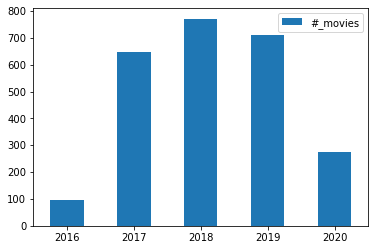

In [50]:
index = ['2016', '2017', '2018',
         '2019', '2020']
df_plot = pd.DataFrame({'#_movies': movies_in_year}, index=index)
ax = df_plot.plot.bar(rot=0)

Looks like we cannot truly claim to represent 2016 data..

In [51]:
# turn $2,000 into 2000
df['domestic_revenue'] = df['domestic_revenue'].str.replace(',', '')
df['domestic_revenue'] = df['domestic_revenue'].str.replace('$', '')
df['domestic_revenue'] = pd.to_numeric(df['domestic_revenue'])
df['international_reveneue'] = df['international_reveneue'].str.replace(',', '')
df['international_reveneue'] = df['international_reveneue'].str.replace('$', '')
df['international_reveneue'] = pd.to_numeric(df['international_reveneue'])
df['world_revenue'] = df['world_revenue'].str.replace(',', '')
df['world_revenue'] = df['world_revenue'].str.replace('$', '')
df['world_revenue'] = pd.to_numeric(df['world_revenue'])
df['opening_revenue'] = df['opening_revenue'].str.replace(',', '')
df['opening_revenue'] = df['opening_revenue'].str.replace('$', '')
df['opening_revenue'] = pd.to_numeric(df['opening_revenue'])

# With clean data, we can ask: what do we care about? What looks related?

Text(74.40624999999999, 0.5, 'Category')

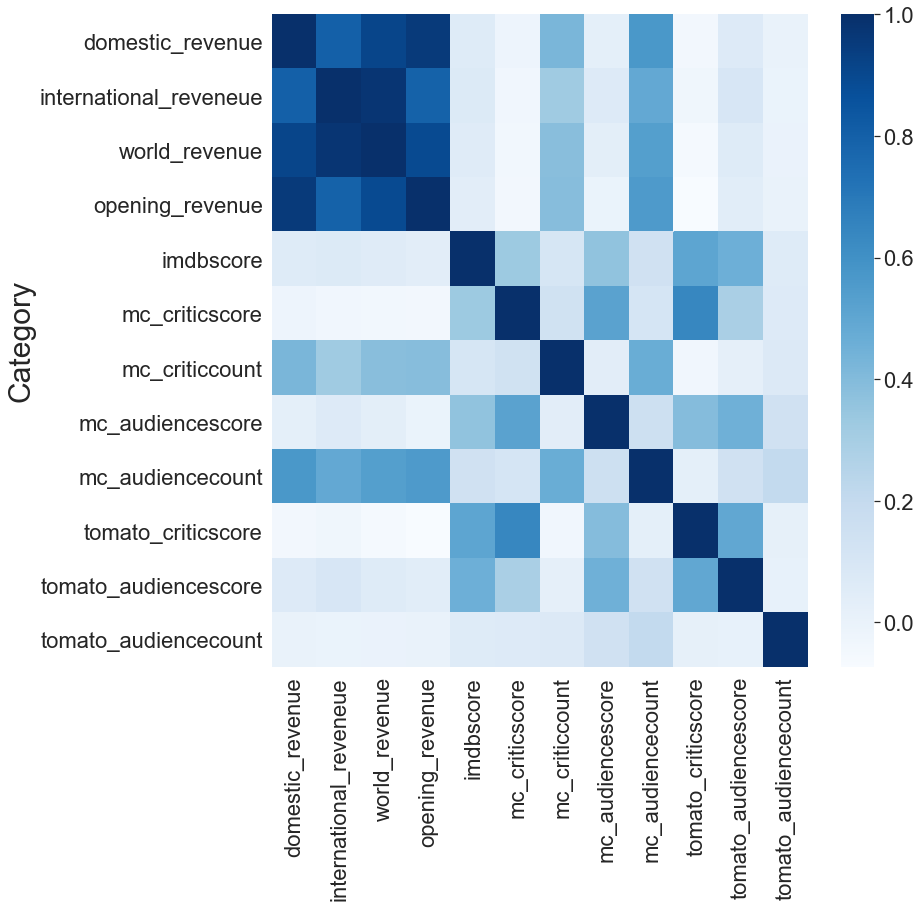

In [52]:
plt.figure(figsize=(12,12))
cor = df.corr()

sns.set(font_scale = 2)

a =sns.heatmap(cor, annot=False, cmap="Blues")

a.set_ylabel("Category",fontsize=30)

## Looks like IMDB, RottenTomates and Metacritic have different opinions

Just from a heatmap, we can convince ourselves that film critique is subjective: varying across Metacritic, RottenTomatoes, and IMDB, relationships are about .51 or .64. This is **almost like** domain knowledge, as if we are pretending to know different population's preferences, or trying to validate if those can be assumed as random. As if we were trying to ask "can I assume reviews ot be consistent throughout a population?" 

In turn, it's surprising that ciritcscores are unrelated to revenue (whereas critic **counts** are), our capitalistic mind would think that a higher grossing film would get better ratings. 

Regardless of that, seeing as there's little relationships between them, it's better to go with the score that is the most normal.

## Seeing as that is, which one is the most trustworthy to use?

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

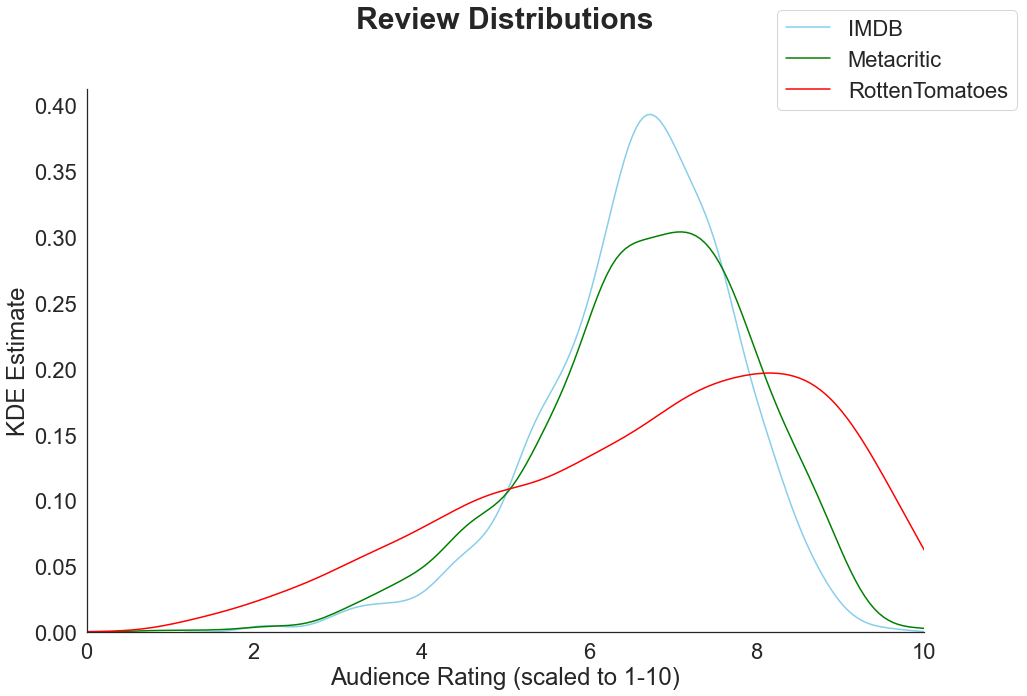

In [55]:
sns.set(font_scale = 2)

sns.set_style(style='white') 
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot( df["imdbscore"] , color="skyblue", label="IMDB's score",hist=None)
sns.distplot( df["mc_audiencescore"]/10 , color="green", label="RottenTomatoe's audience score",hist=None)

sns.distplot( df["tomato_audiencescore"]/10 , color="red", label="RottenTomatoe's audience score", hist=None)
fig.legend(labels=['IMDB','Metacritic', 'RottenTomatoes'])
ax.set_title("Review Distributions", fontsize=30, weight='bold', y=1.1)
ax.set(xlabel="Audience Rating (scaled to 1-10)",
       ylabel="KDE Estimate", xlim=(0, 10))
sns.despine()

/Users/liamisaacs/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


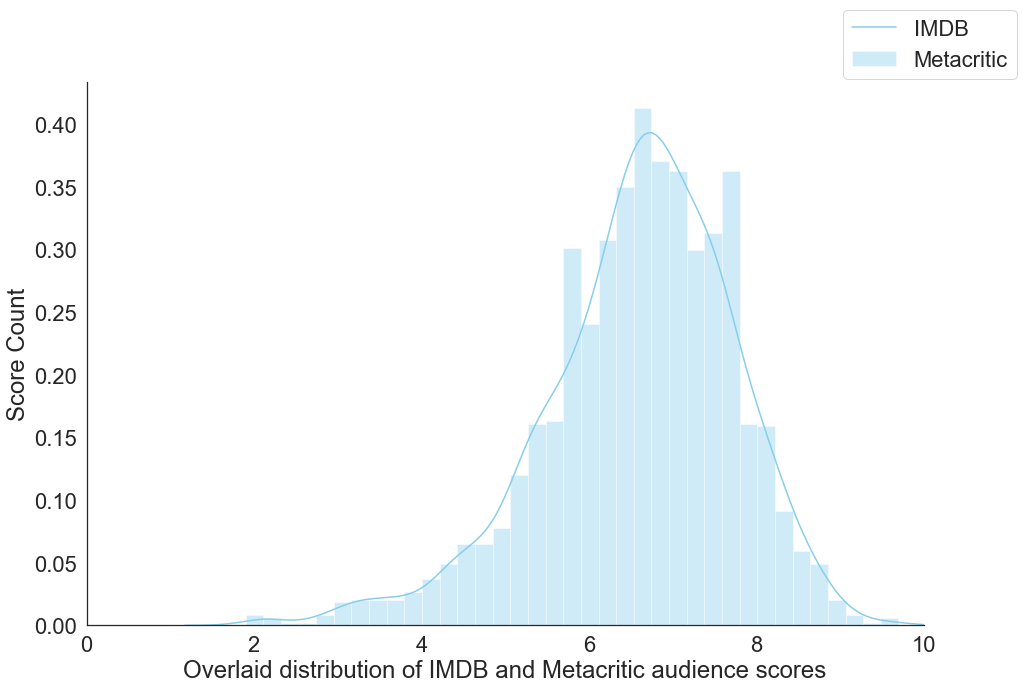

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot( df["imdbscore"] , color="skyblue", label="IMDB's score")
fig.legend(labels=['IMDB','Metacritic'])

ax.set(xlabel="Overlaid distribution of IMDB and Metacritic audience scores",
       ylabel="Score Count", xlim=(0, 10))
title = "IMDB Score Distributions"
sns.despine()

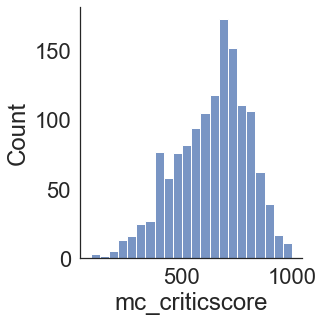

In [57]:
sns.displot(df, x="mc_criticscore")

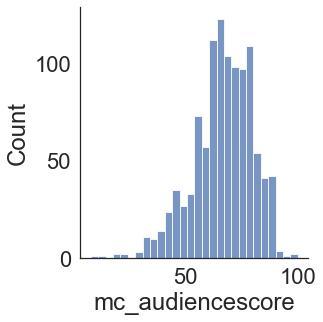

In [58]:
sns.displot(df, x="mc_audiencescore")

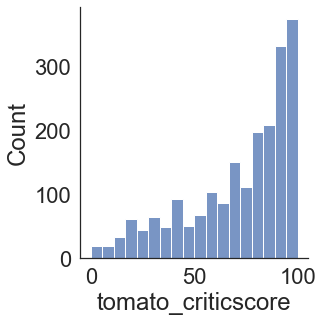

In [59]:
sns.displot(df, x="tomato_criticscore")

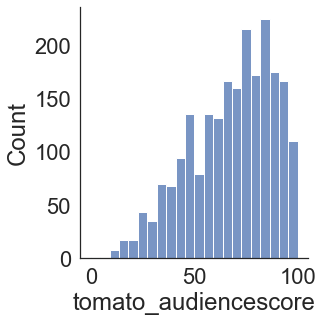

In [60]:
sns.displot(df, x="tomato_audiencescore")

## IMDB

As is evidence in the graphs above, IMDB is the most normal distribution. We will analyze data using IMDB ratings alone.

## Towards a new dataframe


In [61]:
df.info

<bound method DataFrame.info of                                              mojo_title  domestic_revenue  \
0                                        Made in France            9956.0   
1                                                Realms             147.0   
2                                 Postcards from London            5312.0   
3                                        Over the Limit            3243.0   
4     Tall Tales from the Magical Garden of Antoon K...             220.0   
...                                                 ...               ...   
2772                                  The Invisible Man        70410000.0   
2773                                           Dolittle        77047065.0   
2774                                      Birds of Prey        84158461.0   
2775                                 Sonic the Hedgehog       148974665.0   
2776                                  Bad Boys for Life       206305244.0   

      international_reveneue  world_revenue

In [62]:
df_new = df
df_new = df_new.drop(columns=['domestic_revenue', 'international_reveneue', 'opening_revenue',
                              'imdbpicture', 'imdb_metacritic', 'mc_criticscore', 'mc_criticcount',
                            'mc_audiencescore', 'mc_audiencecount', 'url', 'tomato_title',
                            'tomato_criticscore', 'tomato_audiencescore', 'tomato_criticcount',
                            'tomato_audiencecount', 'tomato_image'], axis=1)

#df_new['domestic_international_ratio'] = df['domestic_revenue'] / df['international_reveneue']

#let's drop revenues, as those present the risk of multicolinearity
# df_new = df_new.drop(columns=['domestic_revenue', 'international_reveneue', 'opening_revenue']).head(2)

In [63]:
df_new.head()

,mojo_title,world_revenue,distributor,opening_theaters,budget,MPAA,genres,release_days,release_year,imdbscore,imdbcount
0,Made in France,9956.0,Under The Milky Way,2 theaters,NaN,NaN,"Crime, Drama, Thriller","Sep 23, 2016",2016,6.2,563379
1,Realms,22443.0,The Film Arcade,3 theaters,NaN,R,"Horror, Mystery","Sep 7, 2018",2018,5.5,112304
2,Postcards from London,15548.0,Strand Releasing,1 theater,NaN,NaN,Drama,"Nov 9, 2018",2018,5.1,212816
3,Over the Limit,3243.0,Film Movement,2 theaters,NaN,NaN,"Documentary, Sport","Oct 12, 2018",2018,7.4,62252
4,Tall Tales from the Magical Garden of Antoon K...,14340726.0,Viva Pictures,20 theaters,NaN,PG,"Adventure, Animation, Comedy, Family","Jan 11, 2019",2019,4.6,437340


## Let's analyze genre: one-hot-encoding

To add in our first feature, genre, we need to one-hot-encode this genre column.

In [64]:
df_new['genres'].isnull().values.any()

True

In [65]:
df_new[df_new.duplicated(subset=['genres'])].sort_values(by='mojo_title')
#NaN columns at the bottom, safe to remove
df_new = df_new.dropna(subset=['genres'])

In [66]:
df_new['imdbscore'].isnull().values.any()

True

In [67]:
df_new = df_new.dropna(subset=['imdbscore'])

In [69]:
df_new.info

<bound method DataFrame.info of                                              mojo_title  world_revenue  \
0                                        Made in France         9956.0   
1                                                Realms        22443.0   
2                                 Postcards from London        15548.0   
3                                        Over the Limit         3243.0   
4     Tall Tales from the Magical Garden of Antoon K...     14340726.0   
...                                                 ...            ...   
2765                                    The New Mutants     46766745.0   
2768                                      The Gentlemen    115171795.0   
2772                                  The Invisible Man    143151000.0   
2774                                      Birds of Prey    201858461.0   
2776                                  Bad Boys for Life    426505244.0   

                            distributor opening_theaters       budget   MPAA  \

In [70]:
# df['opening_theaters'] = df['opening_theaters'].str.extract(r'([^\s]+)')
# df['opening_theaters'] = df['opening_theaters'].str.replace(',', '')
# df['opening_theaters'] = pd.to_numeric(df['opening_theaters'])
genres = np.unique(', '.join(df_new['genres']).split(', '))
genres = np.delete(genres, np.where(genres == 'NA'))
for genre in genres:
    df_new[genre] = df_new['genres'].str.contains(genre).astype('int')
df_new.drop('genres', axis=1, inplace=True)

In [71]:
df_new.sample(10)

,mojo_title,world_revenue,distributor,opening_theaters,budget,MPAA,release_days,release_year,imdbscore,imdbcount,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1408,Superman,233585.0,Fathom Events,394 theaters,"$55,000,000",PG,"Nov 25, 2018",2018,6.4,Link error,...,0,0,0,0,1,0,0,0,0,0
2067,Manolo: the Boy Who Made Shoes for Lizards,64889.0,Music Box Films,11 theaters,NaN,NaN,"Sep 15, 2017",2017,6.4,3840,...,0,0,0,0,0,0,0,0,0,0
1677,The Happytime Murders,27506452.0,STX Entertainment,"3,256 theaters","$40,000,000",R,"Aug 24, 2018",2018,5.4,2334,...,0,1,0,0,0,0,0,1,0,0
1607,The Sisters Brothers,13143056.0,Annapurna Pictures,"1,141 theaters",NaN,R,NaN,nan,7.0,Link error,...,0,0,0,0,0,0,0,0,0,1
692,Wild Rose,7123449.0,Neon,195 theaters,NaN,R,"Jun 21, 2019",2019,7.2,418929,...,0,0,0,0,0,0,0,0,0,0
1592,Murder on the Orient Express,352789811.0,Twentieth Century Fox,"3,354 theaters","$55,000,000",PG-13,"Nov 10, 2017",2017,6.5,NaN,...,0,1,0,0,0,0,0,0,0,0
881,The LEGO Movie 2: The Second Part,192306508.0,Warner Bros.,"4,303 theaters","$99,000,000",PG,"Feb 8, 2019",2019,6.6,54799,...,1,0,0,0,0,0,0,0,0,0
2737,The Broken Hearts Gallery,4781389.0,TriStar Pictures,"2,221 theaters",NaN,PG-13,"Sep 11, 2020",2020,6.2,NaN,...,0,0,0,1,0,0,0,0,0,0
1410,Alien Intrusion: Unmasking a Deception,237411.0,Fathom Events,727 theaters,NaN,NaN,"Jan 11, 2018",2018,5.3,433,...,0,0,0,0,0,0,0,0,0,0
216,Chasing Einstein,24057.0,Atlas Distribution Company,4 theaters,NaN,NaN,"Sep 13, 2019",2019,7.2,132,...,0,0,0,0,0,0,0,0,0,0


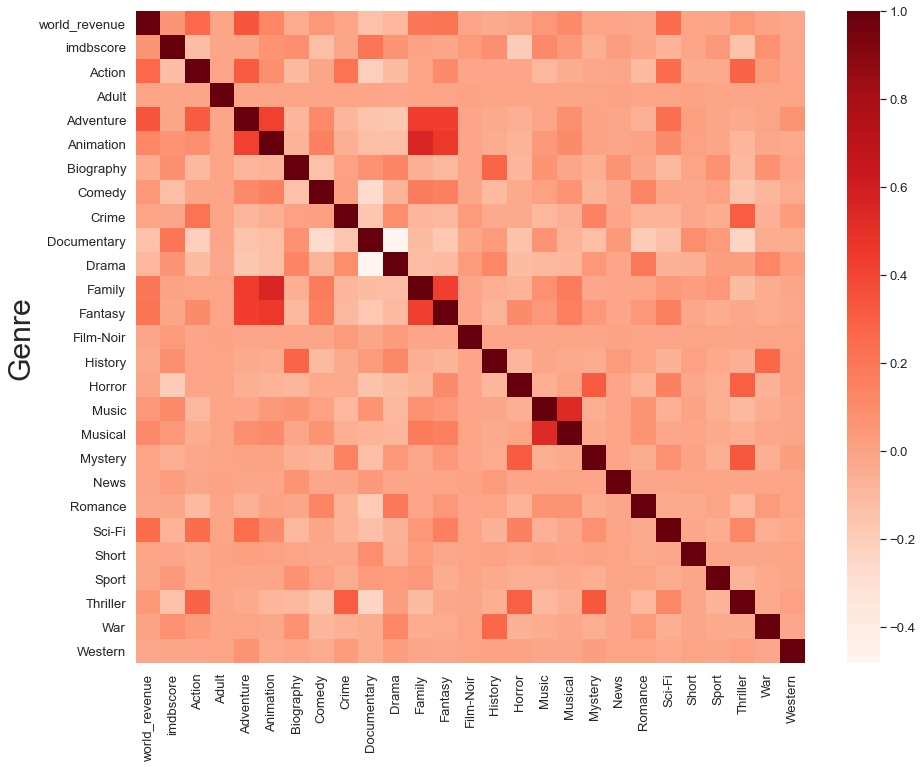

In [72]:

sns.set(font_scale = 1.2)
plt.figure(figsize=(15,12))
cor = df_new.corr()
b = sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
b.set_ylabel("Genre",fontsize=30)
plt.savefig('heatmap_2.svg', dpi=500)

## Linear regression w/ Genre

Validation method: Train / Validation / Test

In [73]:
#hold 20% for final testing
X, y = df_new, df_new['imdbscore']
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=3)

Target: IMDB score; features: genres; question: do people like one genre over the other?

In [75]:
target = df_new['imdbscore']
features = df_new[['world_revenue', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
               'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
               'News', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']]

In [76]:
linear_obj = LinearRegression()
linear_obj.fit(features, target)
linear_obj.score(features, target)

0.1480629761036255

Add-in distributors

In [77]:
df_new[df_new.duplicated(subset=['distributor'])].info

<bound method DataFrame.info of                                  mojo_title  world_revenue  \
7                             A Breath Away      2842040.0   
10                         I Am Not A Witch       182462.0   
14                Narcissister Organ Player        15334.0   
20              For Those Who Don't Read Me        36506.0   
21    American Playhouse: The Killing Floor         1583.0   
...                                     ...            ...   
2765                        The New Mutants     46766745.0   
2768                          The Gentlemen    115171795.0   
2772                      The Invisible Man    143151000.0   
2774                          Birds of Prey    201858461.0   
2776                      Bad Boys for Life    426505244.0   

                            distributor opening_theaters       budget   MPAA  \
7                     Entertainment One      12 theaters          NaN    NaN   
10                        Film Movement       8 theaters       

In [78]:
count = df_new["distributor"].isna().sum()
print(count)

0


In [79]:
distributors = df.distributor.value_counts()
distributors

Fathom Events             217
IFC Films                 102
Warner Bros.               79
Indican Pictures           75
Magnolia Pictures          73
                         ... 
Area 23a                    1
Joma Films                  1
Factory 25                  1
River Rain Productions      1
New Line Cinema             1
Name: distributor, Length: 271, dtype: int64

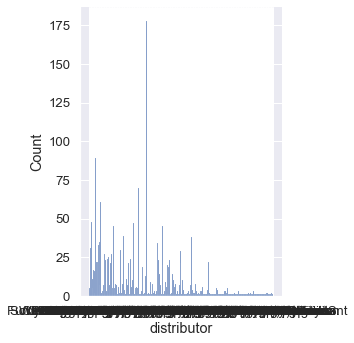

In [80]:
sns.displot(df_new, x="distributor")

In [83]:
other_distributors = list(distributors[distributors <= 30].index)


In [84]:
len(other_distributors)


248

In [85]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [86]:
X5 = df_new.copy()

X5['distributor'] = df_new['distributor'].replace(other_distributors, 'Other')
X5['distributor'] = X5['distributor'].str.replace(" ","")


In [87]:
X5[X5['mojo_title'] == 'Worlds Apart']

,mojo_title,world_revenue,distributor,opening_theaters,budget,MPAA,release_days,release_year,imdbscore,imdbcount,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
2068,Worlds Apart,5011560.0,Other,2 theaters,NaN,NaN,"Jan 13, 2017",2017,7.4,3629,...,0,0,0,1,0,0,0,0,0,0


In [88]:
X5 = pd.get_dummies(X5, columns=['distributor'])

In [89]:
X5.columns

Index(['mojo_title', 'world_revenue', 'opening_theaters', 'budget', 'MPAA',
       'release_days', 'release_year', 'imdbscore', 'imdbcount', 'Action',
       'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Thriller', 'War', 'Western', 'distributor_A24',
       'distributor_Abramorama', 'distributor_CohenMediaGroup',
       'distributor_FathomEvents', 'distributor_FilmMovement',
       'distributor_FocusFeatures', 'distributor_IFCFilms',
       'distributor_IndicanPictures', 'distributor_KinoLorber',
       'distributor_Lionsgate', 'distributor_MagnoliaPictures',
       'distributor_Neon', 'distributor_Oscilloscope', 'distributor_Other',
       'distributor_ParamountPictures', 'distributor_RoadsideAttractions',
       'distributor_SonyPicturesClassics',
       'distributor_SonyPicturesEnterta

In [90]:
X5


,mojo_title,world_revenue,opening_theaters,budget,MPAA,release_days,release_year,imdbscore,imdbcount,Action,...,distributor_ParamountPictures,distributor_RoadsideAttractions,distributor_SonyPicturesClassics,distributor_SonyPicturesEntertainment(SPE),distributor_StrandReleasing,distributor_TwentiethCenturyFox,distributor_UniversalPictures,distributor_WaltDisneyStudiosMotionPictures,distributor_WarnerBros.,distributor_WellGoUSAEntertainment
0,Made in France,9956.0,2 theaters,NaN,NaN,"Sep 23, 2016",2016,6.2,563379,0,...,0,0,0,0,0,0,0,0,0,0
1,Realms,22443.0,3 theaters,NaN,R,"Sep 7, 2018",2018,5.5,112304,0,...,0,0,0,0,0,0,0,0,0,0
2,Postcards from London,15548.0,1 theater,NaN,NaN,"Nov 9, 2018",2018,5.1,212816,0,...,0,0,0,0,1,0,0,0,0,0
3,Over the Limit,3243.0,2 theaters,NaN,NaN,"Oct 12, 2018",2018,7.4,62252,0,...,0,0,0,0,0,0,0,0,0,0
4,Tall Tales from the Magical Garden of Antoon K...,14340726.0,20 theaters,NaN,PG,"Jan 11, 2019",2019,4.6,437340,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,The New Mutants,46766745.0,"2,754 theaters",NaN,PG-13,"Aug 28, 2020",2020,5.3,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2768,The Gentlemen,115171795.0,"2,675 theaters","$22,000,000",R,"Jan 24, 2020",2020,7.8,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2772,The Invisible Man,143151000.0,"3,636 theaters","$7,000,000",R,"Feb 28, 2020",2020,7.1,NaN,0,...,0,0,0,0,0,0,1,0,0,0
2774,Birds of Prey,201858461.0,"4,236 theaters","$84,500,000",R,"Feb 7, 2020",2020,6.1,NaN,1,...,0,0,0,0,0,0,0,0,1,0


In [91]:
add_in_more_features = X5.iloc[:, 10:]

In [92]:
add_in_more_features.columns

Index(['Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Thriller', 'War', 'Western', 'distributor_A24',
       'distributor_Abramorama', 'distributor_CohenMediaGroup',
       'distributor_FathomEvents', 'distributor_FilmMovement',
       'distributor_FocusFeatures', 'distributor_IFCFilms',
       'distributor_IndicanPictures', 'distributor_KinoLorber',
       'distributor_Lionsgate', 'distributor_MagnoliaPictures',
       'distributor_Neon', 'distributor_Oscilloscope', 'distributor_Other',
       'distributor_ParamountPictures', 'distributor_RoadsideAttractions',
       'distributor_SonyPicturesClassics',
       'distributor_SonyPicturesEntertainment(SPE)',
       'distributor_StrandReleasing', 'distributor_TwentiethCenturyFox',
       'distributor_UniversalPictures',
       'distributor_Walt

In [93]:
new_lr = LinearRegression()
new_lr.fit(add_in_more_features, target)
new_lr.score(add_in_more_features, target)


0.17249526511983793

Nice, that raised our R^2 by .3!

In [ ]:
new_lr.coef_

What if I minimize the size of these coefficients..

LASSO/RIDGE regression

#1 lasso

In [94]:
add_in_more_features.columns
more_features_list = add_in_more_features.columns.values.tolist()


In [95]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X5, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [96]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train.loc[:,more_features_list], y_train)
list(zip(more_features_list, lasso_model.coef_))

[('Adult', -0.0),
 ('Adventure', -0.0),
 ('Animation', 0.3117850245367316),
 ('Biography', 0.0),
 ('Comedy', -0.0664152339898354),
 ('Crime', 0.07362948293958244),
 ('Documentary', 0.6516601969635661),
 ('Drama', 0.3236091879703434),
 ('Family', -0.0),
 ('Fantasy', -0.0),
 ('Film-Noir', 0.0),
 ('History', 0.0),
 ('Horror', -0.4007048947181228),
 ('Music', 0.21384551468329696),
 ('Musical', -0.0),
 ('Mystery', 0.0),
 ('News', 0.0),
 ('Romance', -0.0),
 ('Sci-Fi', -0.00856959929186524),
 ('Short', -0.0),
 ('Sport', 0.0),
 ('Thriller', -0.06972870481666894),
 ('War', 0.1497497297712556),
 ('Western', 0.0),
 ('distributor_A24', 0.0),
 ('distributor_Abramorama', 0.0),
 ('distributor_CohenMediaGroup', 0.0),
 ('distributor_FathomEvents', 0.09581399932740185),
 ('distributor_FilmMovement', -0.0),
 ('distributor_FocusFeatures', 0.0),
 ('distributor_IFCFilms', -0.0),
 ('distributor_IndicanPictures', -0.4602748351627256),
 ('distributor_KinoLorber', 0.0),
 ('distributor_Lionsgate', -0.0),
 ('dist

In [97]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.8084772134764259

Yay some of the coefficients have been zeroed-out!

#2 Ridge

In [99]:
lr_model_ridge = Ridge(alpha = 0.01)
lr_model_ridge.fit(X_train.loc[:,more_features_list], y_train)
list(zip(more_features_list, lr_model_ridge.coef_))



[('Adult', -0.7246668400615186),
 ('Adventure', -0.07043762144557242),
 ('Animation', 0.6908376201791865),
 ('Biography', -0.06331833560510207),
 ('Comedy', -0.08773363200574946),
 ('Crime', 0.1904941742689602),
 ('Documentary', 0.7237680785393781),
 ('Drama', 0.3904208863471593),
 ('Family', -0.26213762809559005),
 ('Fantasy', -0.10487379183984187),
 ('Film-Noir', 1.4619134304436845),
 ('History', 0.0792927863070151),
 ('Horror', -0.40206470100189895),
 ('Music', 0.4115090435911601),
 ('Musical', -0.25640959177546013),
 ('Mystery', 0.11818671610644196),
 ('News', 0.37903764183993666),
 ('Romance', -0.0741733967031093),
 ('Sci-Fi', -0.17543705219440694),
 ('Short', -0.6700369369470623),
 ('Sport', 0.32272297497140384),
 ('Thriller', -0.15945970688291933),
 ('War', 0.3870251945818162),
 ('Western', 0.10355879532347217),
 ('distributor_A24', -0.06672873770515876),
 ('distributor_Abramorama', 0.08212780922149868),
 ('distributor_CohenMediaGroup', 0.09821499807789844),
 ('distributor_Fatho

Minimizes the coefficients still, but still we have so many features the model becomes hard to read

In [98]:
test_set_pred = lasso_model.predict(X_test.loc[:,more_features_list])


[]

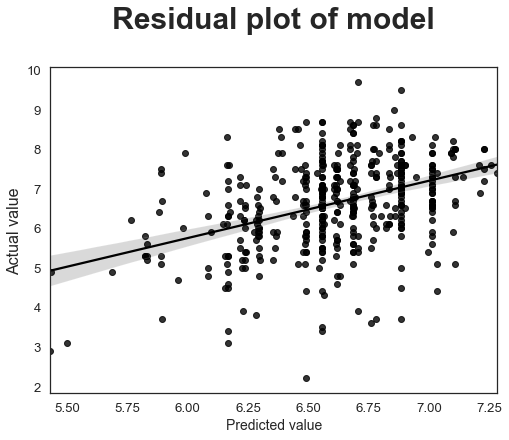

In [112]:
%matplotlib inline
plt.figure(figsize=(8, 6))
sns.set_style(style='white') 
# plt.scatter(test_set_pred, y_test, alpha=.1,  scatter_kws={"color": "black"}, line_kws={"color": "red"})
ax = sns.regplot(x=test_set_pred, y=y_test, color="black")
ax.set_title("Residual plot of model", fontsize=30, weight='bold', y=1.1)

plt.xlabel('Predicted value', fontsize=14)
plt.ylabel('Actual value', fontsize=16)
plt.plot()

In [ ]:
df['predicted_imdb'] = lasso_model.prext()

In [101]:
r2_score(y_test, test_set_pred)


0.14175884367433378

In [100]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.8084772134764259

Tr > Te by .1, which indicates we are *overfitting*. We can use **stronger regularization** to combat this problem, we can try to manually change alpha, or we can find the best value of the regularization strength programmatically.

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X_train.loc[:,more_features_list])


In [104]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

NameError: name 'alphalist' is not defined

In [ ]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried
np.min(err_vec_val)

In [ ]:
## This is the value of alpha that gave us the lowest error

alphalist[np.argmin(err_vec_val)]


### Cross-validate with LassoCV to find the best alpha

Instead of using a program to plot error as we change alpha (on validation data), and taking the minimum of that slope, we can use cross-validation. Here, we run 5-fold cross-validation to retrive the optimal value of alpha

In [ ]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train.loc[:,more_features_list], y_train)

In [ ]:
lasso_model.alpha_


By cross-validating and by using calculus (find min.), we reason the best value of alpha we will get is 0.01.

Refit it...

In [ ]:
list(zip(X_train.columns, lasso_model.coef_))


In [ ]:
mae(y_test, test_set_pred)


In [ ]:
X5

In [ ]:
y = X5['imdbscore']


In [ ]:
len(y)

In [102]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X5.loc[:,more_features_list], y)

X5['pred'] = lasso_model.predict(X5.loc[:,more_features_list])

In [ ]:
X5

In [ ]:
df_final = df.merge(X5, on="mojo_title", how="right")

In [ ]:
df_final.columns

In [103]:
r2_score(y_test, test_set_pred)


0.14175884367433378

In [ ]:
from sklearn.linear_model import lars_path


Stepwise regression is a variable selection procedure for independent variables. It consists of a series of steps designed to find the most useful X-variables to include in a regression model.

It's a *forward selection* process since once a variable is selected it cannot be removed from the model.



In [ ]:
X, y = df_new, df_new['imdbscore']

In [ ]:
lasso_model = Lasso(alpha = 0.01) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X.loc[:,more_features_list], y)
list(zip(more_features_list, lasso_model.coef_))

In [ ]:
X5['pred'] = test_

In [ ]:
mangodb_df = df.merge()

can always get back to title since index order is const. || look at residuals then join movie titles back in

--

- use standard scaler & a couple lines of code to incorporate LASSO/RIDGE regression
- 

- ratio btwn domestic and international?
- complex movies who don't share the same language
- easy-acceptable movies 
- interactions, horror by this studio is good, mine those sorts of conclusions
- not expecting .8, get it as high as possible
- what movies I can predict well, which ones I can't


In [ ]:
df.info

In [ ]:
df = df.dropna(subset=['imdbscore'])

In [ ]:
df_new.info

In [ ]:
df['imdbscore']